In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from paretoset import paretoset

import model_functions as fmodel

# Matrix ISA Model Example Usage

### Number of Registers to Hide Memory Latency

using larger memories with higher latency requires more matrix registers to acheive high utilization. below is a plot showing how utilization is affected by memory latency for different matrix register counts.

100%|██████████| 100/100 [00:00<00:00, 635.77it/s]


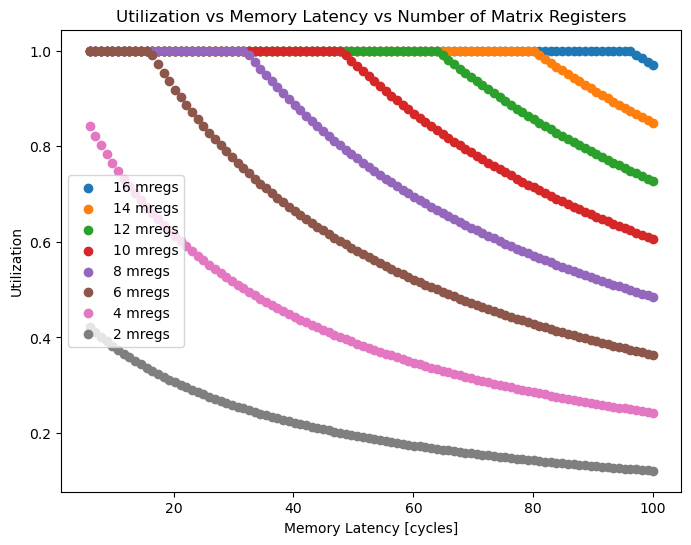

In [2]:
fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Utilization vs Memory Latency vs Number of Matrix Registers')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Utilization')

level = 1
databits = np.array([32])
slice_values = np.linspace(6, 100, 100)
num_mregs = np.array(range(16, 0, -2))
for n in num_mregs:
    perf_model = fmodel.init_pm(databits, t_mem=slice_values, num_mregs=np.array([n]))

    x = perf_model.index.levels[level]
    y = perf_model['util']
    scatter = axs.scatter(x, y, label=f'{n} mregs')
    axs.legend()

100%|██████████| 100/100 [00:00<00:00, 741.32it/s]
/var/folders/hc/58trqhn5091504q0fyxy68jc0000gn/T/ipykernel_11085/839808576.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axs.scatter(x, y, cmap='viridis', s=100)


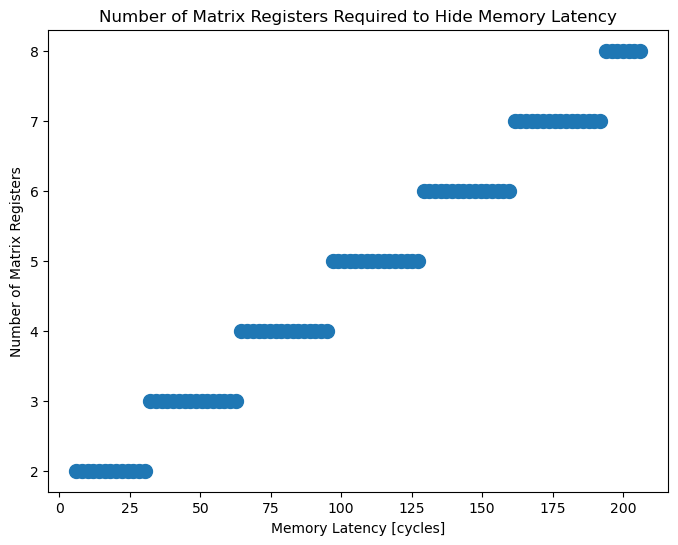

In [3]:
level = 1
slice_values = np.linspace(6,206,100)
perf_model = fmodel.init_pm(t_mem=slice_values)

fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Number of Matrix Registers Required to Hide Memory Latency')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Number of Matrix Registers')

x = perf_model.index.levels[level]
y = perf_model['max_mregs']
scatter = axs.scatter(x, y, cmap='viridis', s=100)

100%|██████████| 100/100 [00:00<00:00, 1063.62it/s]


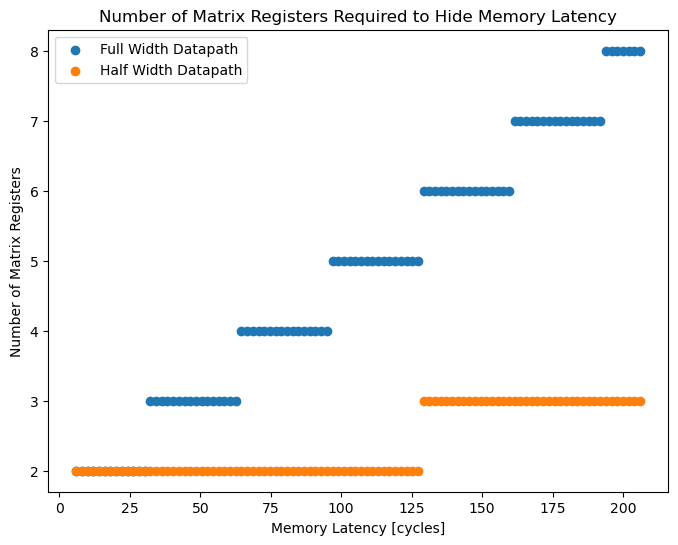

In [4]:
fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Number of Matrix Registers Required to Hide Memory Latency')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Number of Matrix Registers')
scatter = axs.scatter(x, y, label='Full Width Datapath')

level = 1
slice_values = np.linspace(6,206,100)
perf_model = fmodel.init_pm(t_mem=slice_values,width_mmu=np.array([0.5]))

x = perf_model.index.levels[level]
y = perf_model['max_mregs']
scatter = axs.scatter(x, y, label='Half Width Datapath')
axs.legend()

### Exploring Design Space

The model can be used to sweep ranges of the input parameters, and the output performance specs can be visualized using pareto-optimal curves.

With these plots we can visualize the tradeoffs between ngates capacity, memory bandwidth, and performance (operations per cycle).

In [5]:
perf_model = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    N = np.array(range(4,64, 8)),
    M = np.array(range(4,64, 8)),
    K = np.array(range(4,64, 8)),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([0.5, 1])
)
perf_model = perf_model[perf_model['max_mem_bw'] <= 64]
perf_model = perf_model[perf_model['ops_cycle'] >= 1/4e-2]

pm_pareto = perf_model[['ops_cycle','opu_gates', 'max_mem_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

bw = perf_model.loc[mask,'max_mem_bw']
ngates = perf_model.loc[mask,'opu_gates']
opc = perf_model.loc[mask,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Estimated Area [cmos gates]')

scatter = axs.scatter(1/opc, ngates, c=bw, cmap='viridis', s=100)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.colorbar(scatter, ax=axs, label='Memory Bandwidth [Bytes/cycle]')
perf_model[mask]

 63%|██████▎   | 151813/239616 [02:16<01:15, 1162.24it/s]

t_uk  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op width_mmu          
32       20    4  20 4 256      1  64.0 16.0 4         0    0.5         88.0   
               12 20 4 256      1  64.0 20.0 4         0    0.5         96.0   
                                        32.0 4         0    0.5        120.0   
                                        36.0 4         0    0.5        128.0   
                                        40.0 4         0    0.5        136.0   
                                        44.0 4         0    0.5        144.0   
                                        48.0 2         0    0.5        152.0   
               20 20 4 256      1  64.0 24.0 4         0    0.5        104.0   
                                        64.0 4         0    0.5        184.0   
                  28 4 256      1  64.0 60.0 2         0    0.5        176.0   
                  52 4 256      1  64.0 52.0 2         0    0.5        160.0   
               28 52 4 256      1  64.0 48.0 2         0    0.5        152.0   
               36 20 4 256      1  64.0 28.0 4         0    0.5        112.0   
                  36 4 256      1  64.0 64.0 2         0    0.5        184.0   
               44 36 4 256      1  64.0 56.0 2         0    0.5        168.0   

                                                                           util  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op width_mmu             
32       20    4  20 4 256      1  64.0 16.0 4         0    0.5        0.113636   
               12 20 4 256      1  64.0 20.0 4         0    0.5        0.083333   
                                        32.0 4         0    0.5        0.062500   
                                        36.0 4         0    0.5        0.052083   
                                        40.0 4         0    0.5        0.044118   
                                        44.0 4         0    0.5        0.037879   
                                        48.0 2         0    0.5        0.032895   
               20 20 4 256      1  64.0 24.0 4         0    0.5        0.080128   
                                        64.0 4         0    0.5        0.033967   
                  28 4 256      1  64.0 60.0 2         0    0.5        0.026515   
                  52 4 256      1  64.0 52.0 2         0    0.5        0.031250   
               28 52 4 256      1  64.0 48.0 2         0    0.5        0.033260   
               36 20 4 256      1  64.0 28.0 4         0    0.5        0.076531   
                  36 4 256      1  64.0 64.0 2         0    0.5        0.024457   
               44 36 4 256      1  64.0 56.0 2         0    0.5        0.028061   

                                                                       ops_cycle  \
databits t_mem M  N  K l2_cache kl vlB  mlB  num_mregs t_op width_mmu              
32       20    4  20 4 256      1  64.0 16.0 4         0    0.5        29.090909   
               12 20 4 256      1  64.0 20.0 4         0    0.5        26.666667   
                                        32.0 4         0    0.5        32.000000   
                                        36.0 4         0    0.5        30.000000   
                                        40.0 4         0    0.5        28.235294   
                                        44.0 4         0    0.5        26.666667   
                                        48.0 2         0    0.5        25.263158   
               20 20 4 256      1  64.0 24.0 4         0    0.5        30.769231   
                                        64.0 4         0    0.5        34.782609   
                  28 4 256      1  64.0 60.0 2         0    0.5        25.454545   
                  52 4 256      1  64.0 52.0 2         0    0.5        26.000000   
               28 52 4 256      1  64.0 48.0 2         0    0.5        25.543860   
               36 20 4 256      1  64.0 28.0 4         0    0.5        34.285714   
                  36 4 256      1  64.0

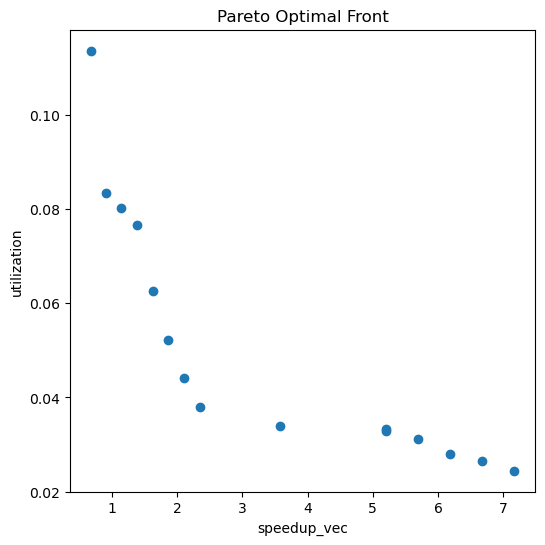

In [6]:
pm_pareto = perf_model[['speedup_vec','util']]
mask = paretoset(pm_pareto, sense=['min', 'min'])

speedup_vec = perf_model.loc[mask,'speedup_vec']
util = perf_model.loc[mask,'util']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('speedup_vec')
axs.set_ylabel('utilization')

scatter = axs.scatter(speedup_vec, util)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
perf_model[mask]

In [81]:

# mlB = np.array(range(128,513, 32))/8
mlB = np.array([128, 256, 512])/8
vlB = np.array([128, 256, 512])/8
num_mregs = np.array(range(2,6,2))
t_op = np.array([0, 1, 2])
width_mmu = np.array([0.5, 1])

def plot_nmk_scatter(x, y):
    fig, axs = plt.subplots(len(t_op), len(width_mmu), figsize=(18, 18))
    for m in range(len(t_op)):
        for n in range(len(width_mmu)):
                perf_model = fmodel.init_pm(t_op=np.array([t_op[m]]), width_mmu=np.array([width_mmu[n]]),                   
                                            N = np.array(range(4,64, 8)),
                                            M = np.array(range(4,64, 8)),
                                            K = np.array(range(4,64, 8)))

                # Create a 3x3 subplot
                ax = axs[m,n]
                ax.set_title(f'Speedup vs Utilization for MLEN={int(mlB[m]*8)} and VLEN={int(8*vlB[n])}')
                ax.set_xlabel('Speedup over Vector Unit')
                ax.set_ylabel('Utilization')
                perf_model['tile_size'] = perf_model.index.get_level_values('N') * perf_model.index.get_level_values('M')
                scatter = ax.scatter(perf_model['speedup_vec'], perf_model['util'],  
                                        c=perf_model['tile_size'], cmap='viridis')
                cbar = plt.colorbar(scatter, ax=ax)
    plt.show()

#### Memory Data Reuse
If the matrices are sufficiently large to reuse tiles, then bandwidth can be decreased:

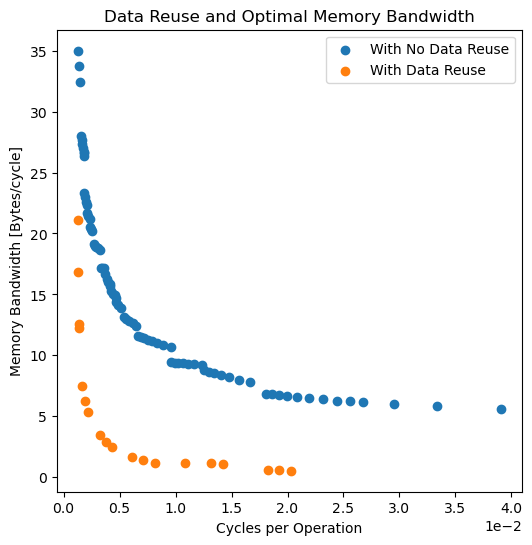

In [11]:
no_reuse_pm = perf_model.copy()
pm_pareto = no_reuse_pm[['ops_cycle','max_mem_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min'])

bw = no_reuse_pm.loc[mask,'max_mem_bw']
opc = no_reuse_pm.loc[mask,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
scatter = axs.scatter(1/opc, bw, label='With No Data Reuse')

reuse_perf_model = perf_model.copy()
reuse_perf_model = reuse_perf_model[reuse_perf_model['mem_bw'] <= 64]
reuse_perf_model = reuse_perf_model[reuse_perf_model['ops_cycle'] >= 1/(4e-2)]

pm_pareto = reuse_perf_model[['ops_cycle','mem_bw']]
reuse_mask = paretoset(pm_pareto, sense=['max', 'min'])

bw = reuse_perf_model.loc[reuse_mask,'mem_bw']
opc = reuse_perf_model.loc[reuse_mask,'ops_cycle']

scatter = axs.scatter(1/opc, bw, label='With Data Reuse')
axs.set_title('Data Reuse and Optimal Memory Bandwidth')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Memory Bandwidth [Bytes/cycle]')
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs.legend()


100%|██████████| 585/585 [00:00<00:00, 1420.15it/s]


,,,,,,,,,,,,t_uk,util,ops_cycle,max_mregs,max_mrf_capacity,mem_bw,max_mem_bw,mrf_capacity,mrf_bw,speedup_vec,macc_gates,mrf_gates,opu_gates,insts_cycle
databits,t_mem,M,N,K,l2_cache,kl,vlB,mlB,num_mregs,t_op,width_mmu,,,,,,,,,,,,,,


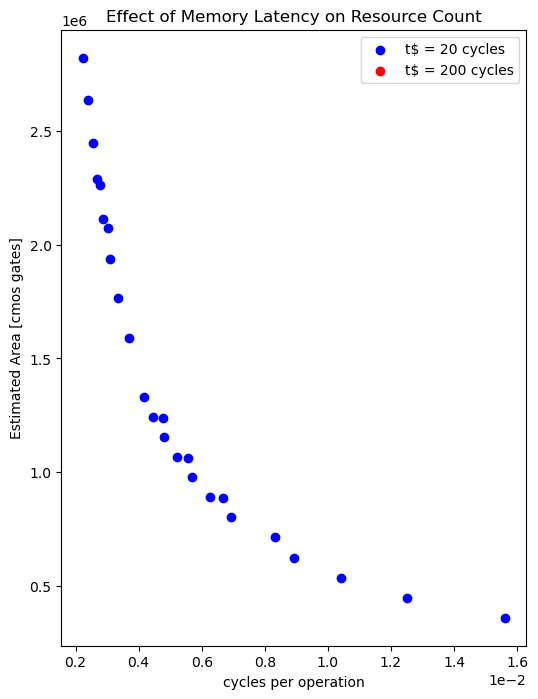

In [12]:
tm20_perf_model = perf_model.copy()
tm200_perf_model = fmodel.init_pm(
    t_mem = np.array([200]),
    l2_cache = np.array([256]),
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([1])
)
tm20_perf_model = tm20_perf_model[tm20_perf_model['mem_bw'] <= 64]
tm20_perf_model = tm20_perf_model[tm20_perf_model['opu_gates'] <= 3.2e6]
tm20_perf_model = tm20_perf_model[tm20_perf_model['ops_cycle'] >= 10]

tm200_perf_model = tm200_perf_model[tm200_perf_model['mem_bw'] <= 64]
tm200_perf_model = tm200_perf_model[tm200_perf_model['opu_gates'] <= 3.2e6]
tm200_perf_model = tm200_perf_model[tm200_perf_model['ops_cycle'] >= 10]

tm20_pm_pareto = tm20_perf_model[['ops_cycle','opu_gates']]
tm20_mask = paretoset(tm20_pm_pareto, sense=['max', 'min'])

tm200_pm_pareto = tm200_perf_model[['ops_cycle','opu_gates']]
tm200_mask = paretoset(tm200_pm_pareto, sense=['max', 'min'])

fig, axs = plt.subplots(1,figsize=(6,8))
axs.set_title('Effect of Memory Latency on Resource Count')
axs.set_xlabel('cycles per operation')
axs.set_ylabel('Estimated Area [cmos gates]')

bw = tm20_perf_model.loc[tm20_mask,'mem_bw']
ngates = tm20_perf_model.loc[tm20_mask,'opu_gates']
opc = tm20_perf_model.loc[tm20_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='b', label='t$ = 20 cycles')

bw = tm200_perf_model.loc[tm200_mask,'mem_bw']
ngates = tm200_perf_model.loc[tm200_mask,'opu_gates']
opc = tm200_perf_model.loc[tm200_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='r', label='t$ = 200 cycles')

axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs.legend()
tm200_perf_model[tm200_mask]

We can compare these tradeoffs for half-width and full-width MMU datapaths:

In [13]:
perf_model = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    N = np.array(range(4,64, 8)),
    M = np.array(range(4,64, 8)),
    K = np.array(range(4,64, 8)),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([0.5, 1])
)
perf_model_t1 = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['max_mem_bw'] <= 64]
bw = perf_model_t1['max_mem_bw']
ngates = perf_model_t1['opu_gates']
opc = perf_model_t1['ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['max_mem_bw'] <= 64]
bw_t4 = perf_model_t4['max_mem_bw']
ngates_t4 = perf_model_t4['opu_gates']
opc_t4 = perf_model_t4['ops_cycle']

fig, axs = plt.subplots(2, figsize=(6, 8))
# Plot for full width datapath
axs[0].set_title('Full Width Datapath')
axs[0].set_xlabel('Cycles per Operation')
axs[0].set_ylabel('Estimated Area [cmos gates]')
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
full = axs[0].scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs[0], label='Full Width BW [Bytes/cycle]')

# Plot for half width datapath
axs[1].set_title('Half Width Datapath')
axs[1].set_xlabel('Cycles per Operation')
axs[1].set_ylabel('Estimated Area [cmos gates]')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
half = axs[1].scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs[1], label='Half Width BW [Bytes/cycle]')
plt.tight_layout()
plt.show()


 23%|██▎       | 55687/239616 [00:40<02:15, 1361.47it/s]


KeyboardInterrupt: 

100%|██████████| 585/585 [00:00<00:00, 1542.57it/s]


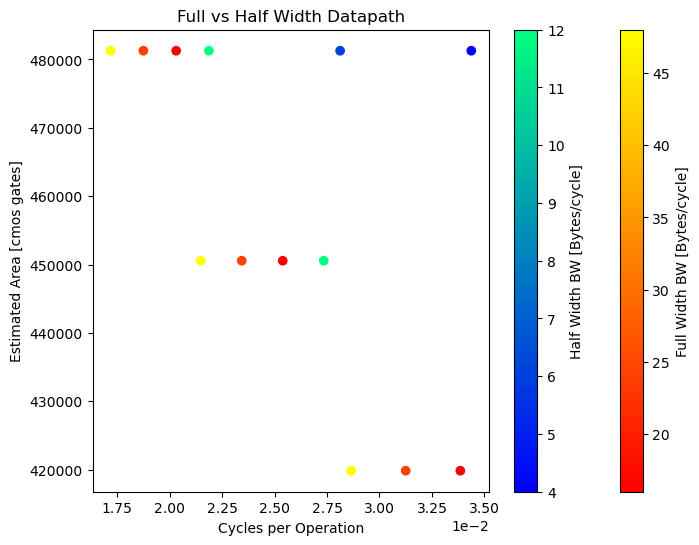

In [ ]:
perf_model_t1 = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    mlB = np.array(range(128,513, 32))/8,
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_mmu = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['max_mem_bw'] <= 64]
perf_model_t1 = perf_model_t1[perf_model_t1['opu_gates'] <= 2e6]
perf_model_t1 = perf_model_t1[perf_model_t1['ops_cycle'] >= 1/3.5e-2]

pm_pareto = perf_model_t1[['ops_cycle','opu_gates', 'max_mem_bw']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

bw = perf_model_t1.loc[mask,'max_mem_bw']
ngates = perf_model_t1.loc[mask,'opu_gates']
opc = perf_model_t1.loc[mask,'ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['max_mem_bw'] <= 64]
perf_model_t4 = perf_model_t4[perf_model_t4['opu_gates'] <= 2e6]
perf_model_t4 = perf_model_t4[perf_model_t4['ops_cycle'] >= 1/3.5e-2]

pm_pareto_t4 = perf_model_t4[['ops_cycle','opu_gates', 'max_mem_bw']]
mask_t4 = paretoset(pm_pareto_t4, sense=['max', 'min', 'min'])

bw_t4 = perf_model_t4.loc[mask_t4,'max_mem_bw']
ngates_t4 = perf_model_t4.loc[mask_t4,'opu_gates']
opc_t4 = perf_model_t4.loc[mask_t4,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(8,6))
axs.set_title('Full vs Half Width Datapath')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Estimated Area [cmos gates]')

full = axs.scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs, label = 'Full Width BW [Bytes/cycle]')

half = axs.scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs, label = 'Half Width BW [Bytes/cycle]')
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


In [ ]:
perf_model_t4.loc[mask_t4]

t_uk  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu         
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5        56.0   
                                           10        0    0.5        88.0   
                                                     1    0.5        72.0   
                                                     2    0.5        56.0   

                                                                         util  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu             
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5        0.571429   
                                           10        0    0.5        0.454545   
                                                     1    0.5        0.555556   
                                                     2    0.5        0.714286   

                                                                     ops_cycle  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu              
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5        36.571429   
                                           10        0    0.5        29.090909   
                                                     1    0.5        35.555556   
                                                     2    0.5        45.714286   

                                                                     max_mregs  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu              
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5              4.0   
                                           10        0    0.5              2.0   
                                                     1    0.5              3.0   
                                                     2    0.5              4.0   

                                                                     max_mrf_capacity  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu                     
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5                 0.37500   
                                           10        0    0.5                 0.18750   
                                                     1    0.5                 0.28125   
                                                     2    0.5                 0.37500   

                                                                     mem_bw  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu           
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5           8.5   
                                           10        0    0.5           2.8   
                                                     1    0.5           4.2   
                                                     2    0.5           8.4   

                                                                     max_mem_bw  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu               
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5              12.0   
                                           10        0    0.5               4.0   
                                                     1    0.5               6.0   
                                                     2    0.5              12.0   

                                                                     mrf_capacity  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu                 
32       20    4 4 4 256      1  16.0 16.0 8         2    0.5              0.7500   
                                           10        0    0.5              0.9375   
                                                     1    0.5              0.9375   
                                                     2    0.5              0.9375   

                                                                        mrf_bw  \
databits t_mem M N K l2_cache k

In [ ]:
perf_model_t1.loc[mask]

t_uk  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu         
32       20    4 4 4 256      1  16.0 16.0 6         0    1          52.0   
                                                     1    1          48.0   
                                                     2    1          44.0   
                                           8         0    1          52.0   
                                                     1    1          48.0   
                                                     2    1          44.0   
                                           10        0    1          52.0   
                                                     1    1          48.0   
                                                     2    1          44.0   

                                                                         util  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu             
32       20    4 4 4 256      1  16.0 16.0 6         0    1          0.461538   
                                                     1    1          0.500000   
                                                     2    1          0.545455   
                                           8         0    1          0.615385   
                                                     1    1          0.666667   
                                                     2    1          0.727273   
                                           10        0    1          0.769231   
                                                     1    1          0.833333   
                                                     2    1          0.909091   

                                                                     ops_cycle  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu              
32       20    4 4 4 256      1  16.0 16.0 6         0    1          29.538462   
                                                     1    1          32.000000   
                                                     2    1          34.909091   
                                           8         0    1          39.384615   
                                                     1    1          42.666667   
                                                     2    1          46.545455   
                                           10        0    1          49.230769   
                                                     1    1          53.333333   
                                                     2    1          58.181818   

                                                                     max_mregs  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu              
32       20    4 4 4 256      1  16.0 16.0 6         0    1                5.0   
                                                     1    1                6.0   
                                                     2    1               11.0   
                                           8         0    1                5.0   
                                                     1    1                6.0   
                                                     2    1               11.0   
                                           10        0    1                5.0   
                                                     1    1                6.0   
                                                     2    1               11.0   

                                                                     max_mrf_capacity  \
databits t_mem M N K l2_cache kl vlB  mlB  num_mregs t_op width_mmu                     
32       20    4 4 4 256      1  16.0 16.0 6         0    1                   0.46875   
                                                     1    1                   0.56250   
                                                     2    1                   1.03125   
                                           8         0    1                   

In [ ]:
# perf_model = fmodel.init_pm(
#     t_mem = np.array([20]),
#     l2_cache = np.array([256, 512]),
#     mlB = np.array(range(128,513, 32))/8,
#     vlB = np.array([128, 256, 512])/8,
#     num_mregs = np.array(range(2,12,2)),
#     t_op = np.array([0, 1, 2]),
#     width_mmu = np.array([1, 0.5])
# )
# perf_model = perf_model[perf_model['ops_cycle'] >= 64]
# perf_model = perf_model[perf_model['opu_gates'] <= 4]

# pm_pareto = perf_model[['ops_cycle','opu_gates', 'mem_bw']]
# mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

# bw = perf_model.loc[mask,'mem_bw']
# ngates = perf_model.loc[mask,'opu_gates']
# opc = perf_model.loc[mask,'ops_cycle']

# fig, axs = plt.subplots(1,figsize=(6,8))
# axs.set_title('int32 ; 20 cycle mem latency')
# axs.set_xlabel('cycles per operation')
# axs.set_ylabel('Estimated Area [cmos gates]')

# scatter = axs.scatter(1/opc, ngates, c=bw, cmap='viridis', s=100)
# fig.colorbar(scatter, ax=axs, label = '$ BW [Bytes/cycle]')
# perf_model[mask]

For a given memory latency, plot: 

flops/utilization acheived with given number of registers

min number of registers for full utilization